In [7]:
# %pip install captcha 
# %pip install opencv-python
# !apt update && apt install -y libsm6 libxext6
# !pip install opencv-python-headless
# !pip install opencv-contrib-python-headless
# %pip install keras
# !pip install tensorflow[and-cuda]
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 3.3 MB/s eta 0:00:0031m12.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 1.3 MB/s eta 0:00:00m eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00m eta 0:00:010:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 8.6 MB/s eta 0:00:000m eta 0:00:010:01:01
Note: you may need to restart the kernel to use updated packages.


In [48]:

import argparse
import json
import string
import os
import shutil
import uuid
from captcha.image import ImageCaptcha

import itertools

import os
import cv2
import numpy as np
from random import random, randint, choices

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input,Reshape
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import threading
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)
    def multiThreading( image,num_of_letters):
        
        for i in itertools.permutations([str(c) for c in range(10)], num_of_letters):
            captcha = ''.join(i)
            fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
            image.write(captcha, fn)
    threads = []
    for counter in range(num_of_repetition):
        print('generating %d/%d' % (counter + 1, num_of_repetition))
        thread = threading.Thread(target=multiThreading, args=(image,num_of_letters))
        threads.append(thread)
        thread.start()
    
    for thread in threads:
        thread.join()

def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')

In [3]:
BATCH_SIZE = 128
NUM_OF_LETTERS = 5
EPOCHS = 50
IMG_ROW, IMG_COLS = 50, 135


# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [7]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, 10))
                for i in range(NUM_OF_LETTERS):
                    label[i, int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)


In [17]:
if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 8 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
generating 1/8
generating 2/8
generating 3/8
generating 4/8
generating 5/8
generating 6/8
generating 7/8
generating 8/8
Finished Data Generation


In [5]:
x_train, y_train, x_test, y_test = load_data(DATA_PATH)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

loading dataset...
dataset size: 241920 (train=217497, test=24423)


In [6]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(217497, 25, 67, 1)
(217497, 5, 10)
(24423, 25, 67, 1)
(24423, 5, 10)


In [4]:
DATA_DIR = './train/data/'
H, W, C = 100, 120, 3  # height, width, 3(RGB channels)
N_LABELS = 256
D = 5 # num_per_image

In [5]:
len(os.listdir('./train/data'))

241920

In [6]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        label, _ = filename.split("_")
        return label
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None

In [7]:
import glob
import pandas as pd
files = glob.glob(os.path.join(DATA_DIR, "*.png"))
attributes = list(map(parse_filepath, files))

df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['label', 'file']
df = df.dropna()
df.head()

,label,file
0,75981,./train/data/75981_000009cc-c77c-4d1a-b5b4-417...
1,20347,./train/data/20347_980a54df-7793-4e72-8938-861...
2,46509,./train/data/46509_373371bf-8b04-4627-8341-f17...
3,45978,./train/data/45978_eec891f7-0851-4494-b382-688...
4,04837,./train/data/04837_be1c1b07-6f1c-48c5-8906-d84...



Data Preprocessing


In [8]:


p = np.random.permutation(len(df))
train_up_to = int(len(df) * 0.7)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

print('train count: %s, valid count: %s, test count: %s' % (
    len(train_idx), len(valid_idx), len(test_idx)))



train count: 118540, valid count: 50804, test count: 72576


In [37]:
from tensorflow.keras.utils import to_categorical
from PIL import Image


def get_data_generator(df, indices, for_training, batch_size=16):
    images, labels = [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, label = r['file'], r['label']
            im = Image.open(file)
#             im = im.resize((H, W))
            im = np.array(im) / 255.0
            images.append(np.array(im))
            labels.append(np.array([np.array(to_categorical(ord(i), N_LABELS)) for i in label]))
            if len(images) >= batch_size:
#                 print(np.array(images), np.array(labels))
                yield (np.array(images), np.array(labels))
                images, labels = [], []
        if not for_training:
            break

Model

In [42]:
# from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.models import Model

input_layer = Input(shape=(50, 135, C))
x = Conv2D(32, 3, activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
# x = layers.Dropout(0.5)(x)

x = Dense(D * N_LABELS, activation='softmax')(x)
x = Reshape((D, N_LABELS))(x)

model = Model(inputs=input_layer, outputs=x)

model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics= ['accuracy'])
model.summary()


Model: "functional_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 50, 135, 3)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 133, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 24, 66, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 22, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 11, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 9, 30, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 4, 15, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     3,933,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1280)           │     1,312,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 5, 256)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,301,504 (20.22 MB)

 Trainable params: 5,301,504 (20.22 MB)

 Non-trainable params: 0 (0.00 B)

Training

In [43]:
batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

In [44]:
x = next(train_gen)
x[0]

array([[[[0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         ...,
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961]],

        [[0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         ...,
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961]],

        [[0.96862745, 0.9372549 , 0.94901961],
         [0.94901961, 0.89803922, 0.88627451],
         [0.94901961, 0.89803922, 0.88627451],
         ...,
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961]],

        ...,

        [[0.96862745, 0.9372549 , 0.94901961],
         [0.96862745, 0.9372549 , 0.94901961]

In [45]:
from tensorflow.keras.callbacks import ModelCheckpoint



callbacks = [
    ModelCheckpoint("./model_checkpoint/model.keras", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=5,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/5


I0000 00:00:1712214969.813642   10292 service.cc:145] XLA service 0x711f200021b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712214969.813673   10292 service.cc:153]   StreamExecutor device (0): Quadro P1000, Compute Capability 6.1
2024-04-04 12:46:09.941319: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-04 12:46:10.173339: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8905


   5/1852 ━━━━━━━━━━━━━━━━━━━━ 1:14 40ms/step - accuracy: 0.0621 - loss: 4.7222

I0000 00:00:1712214975.624912   10292 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1852/1852 ━━━━━━━━━━━━━━━━━━━━ 148s 76ms/step - accuracy: 0.4076 - loss: 1.6325 - val_accuracy: 0.9210 - val_loss: 0.2448
Epoch 2/5
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 93s 50ms/step - accuracy: 0.9376 - loss: 0.1958 - val_accuracy: 0.9580 - val_loss: 0.1338
Epoch 3/5
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 92s 50ms/step - accuracy: 0.9701 - loss: 0.0963 - val_accuracy: 0.9651 - val_loss: 0.1165
Epoch 4/5
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 92s 50ms/step - accuracy: 0.9804 - loss: 0.0625 - val_accuracy: 0.9724 - val_loss: 0.0938
Epoch 5/5
1852/1852 ━━━━━━━━━━━━━━━━━━━━ 93s 50ms/step - accuracy: 0.9853 - loss: 0.0454 - val_accuracy: 0.9743 - val_loss: 0.0927


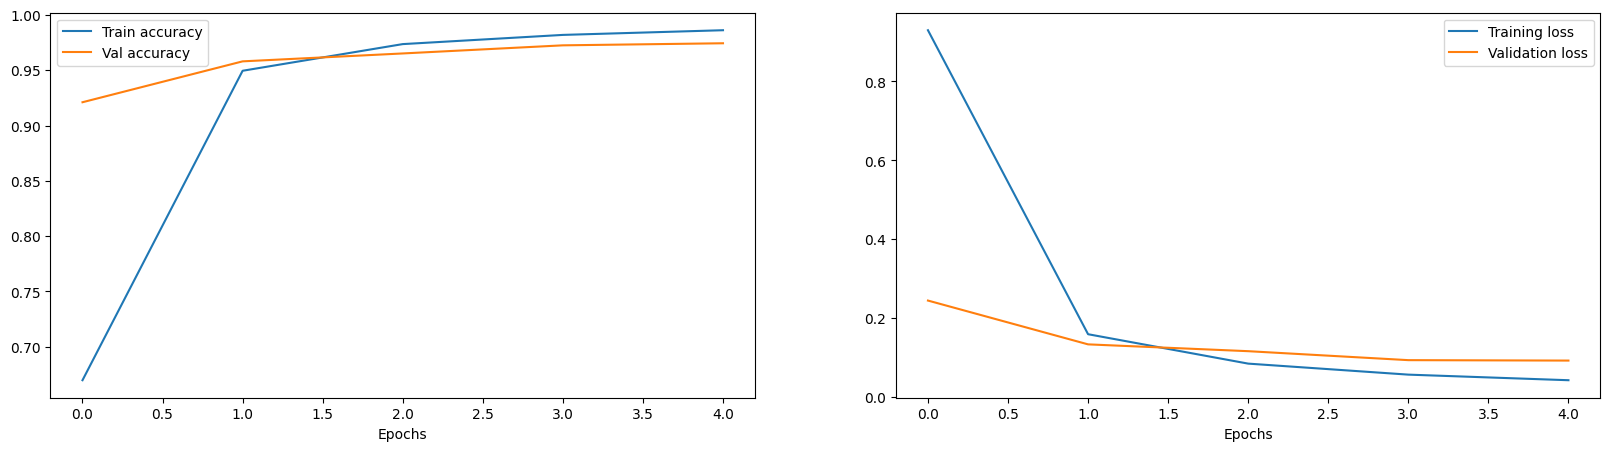

In [46]:
def plot_train_history(history):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].plot(history.history['accuracy'], label='Train accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend() 

    axes[1].plot(history.history['loss'], label='Training loss')
    axes[1].plot(history.history['val_loss'], label='Validation loss')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

plot_train_history(history)
plt.show()

In [47]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

567/567 ━━━━━━━━━━━━━━━━━━━━ 63s 106ms/step - accuracy: 0.9756 - loss: 0.0883


{'loss': 0.09007509797811508, 'compile_metrics': 0.9750970005989075}

In [49]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, y_test = next(test_gen)

y_pred = model.predict_on_batch(x_test)

y_true = tf.math.argmax(y_test, axis=-1)
y_pred = tf.math.argmax(y_pred, axis=-1)


In [50]:
def format_y(y):
    return ''.join(map(lambda x: chr(int(x)), y))

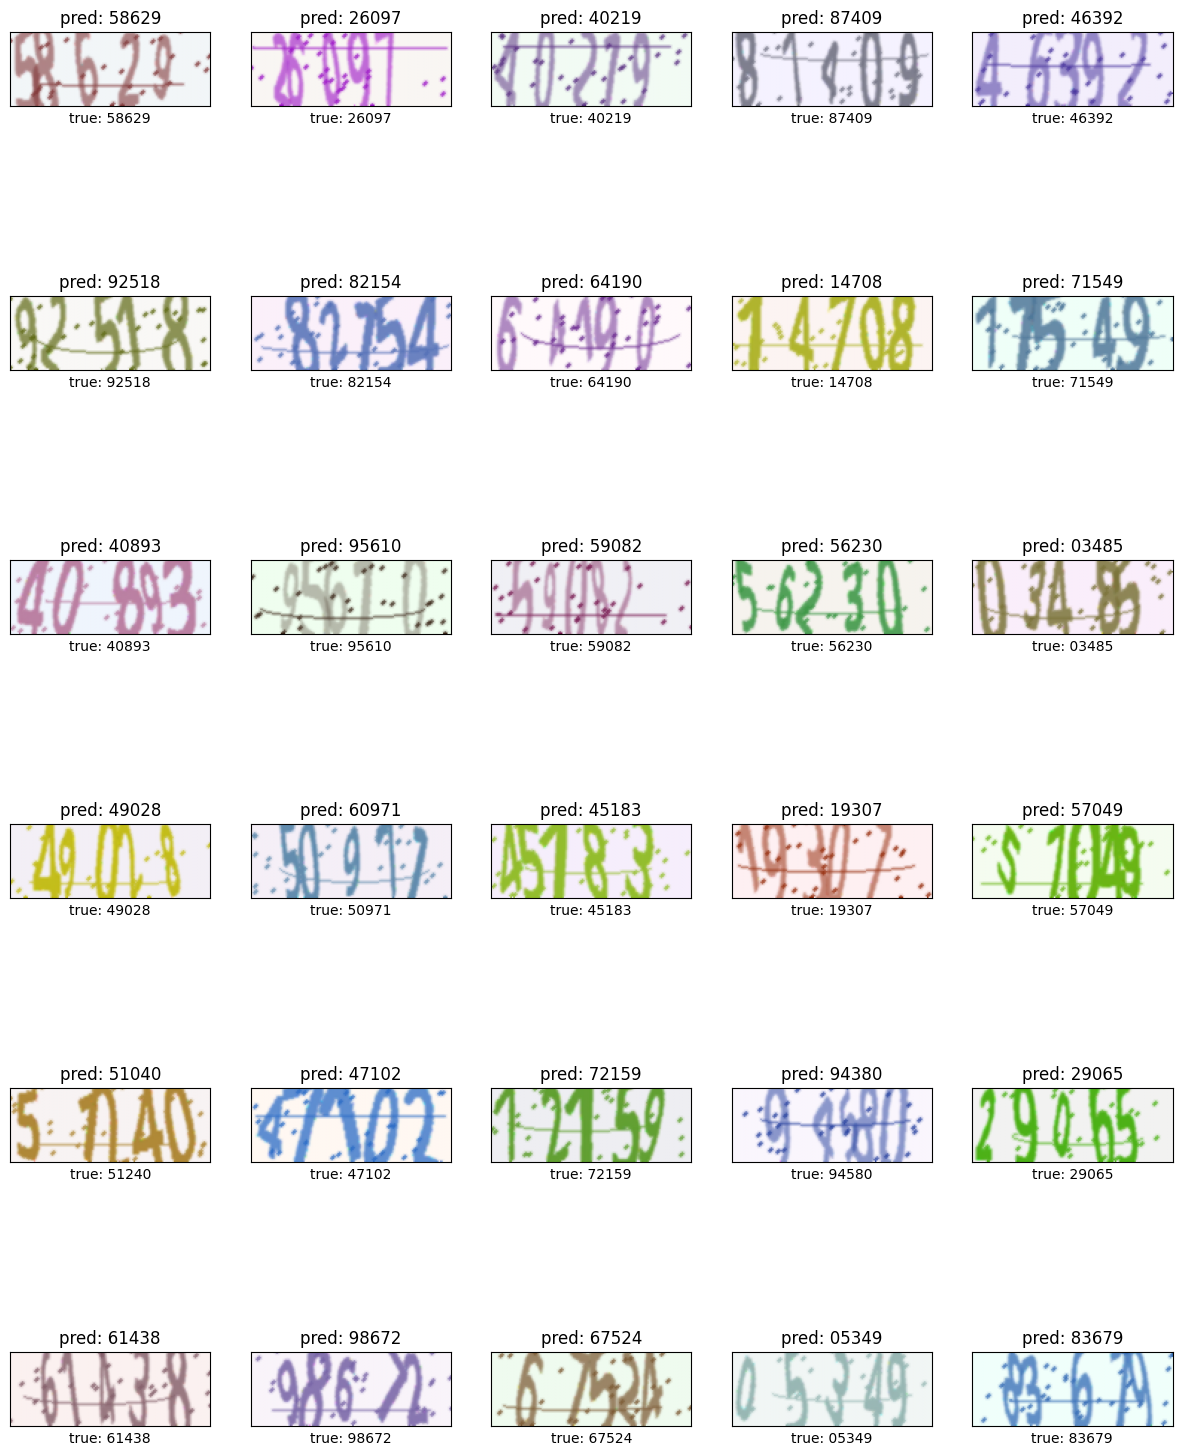

In [51]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('pred: %s' % format_y(y_pred[img_idx]))
    ax.set_xlabel('true: %s' % format_y(y_true[img_idx]))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [56]:

model.save_weights('./checkpoints/model.weights.h5')